In [225]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

init_val={
    'timestamp':60,
    'numChargers' : 12,
    'v2g':False
}


In [230]:

def process_building_load(buildingLoadScaling):
    # Carica il file Excel
    file_path = r'Building_load.xlsx'
    df = pd.read_excel(file_path)

    # Rimuovi spazi bianchi dai valori della colonna "Time"
    df['Time'] = df['Time'].str.strip()

    # Converti la colonna "Time" in formato datetime
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Imposta la colonna "Time" come indice
    df.set_index('Time', inplace=True)

    # Risample i dati ogni 5 minuti calcolando la media
    df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()

    # Converti la colonna "Potenza normalizzata [W]" in un vettore np.array
    potenza_norm_array = df_resampled['Potenza normalizzata [W]'].to_numpy()

    # Calcola il vettore di potenza giornaliero scalando il profilo sul massimo dell'edificio
    potenza_build_array = potenza_norm_array * buildingLoadScaling * 0.7

    return potenza_build_array

def process_pv_production():
    # Leggi il file Excel
    file_path = r'pv_production.xlsx'
    df = pd.read_excel(file_path)

    # Assicurati che le colonne abbiano i nomi corretti
    df.columns = ['Time', 'Value']

    # Converte i dati in un np.array
    original_values = np.array(df['Value'])

    # I tuoi dati originali ogni 15 minuti
    original_time = np.arange(0, 24, 0.25)  # ad esempio da 0 a 24 ore

    # Nuovi intervalli di tempo ogni tot minuti
    new_time = np.arange(0, 24, init_val['timestamp']/60.)  # da 0 a 24 ore, ogni 5 minuti

    # Usa numpy.interp per interpolare i nuovi valori
    new_values = np.interp(new_time, original_time, original_values)

    return new_values

def array_pun():
    # Carica il file Excel
    file_path=r'hourly_price_PUN.xlsx'
    df = pd.read_excel(file_path)
    
    # Supponiamo che la colonna dei prezzi orari si chiami '€/kWh'
    prezzi_orari = df['€/kWh'].values
    
    # Creiamo un array numpy che ripete ogni valore 12 volte (12 * 5 minuti = 1 ora)
    prezzi_5_minuti = np.repeat(prezzi_orari, 60/init_val['timestamp'])
    
    return prezzi_5_minuti

def time_to_index(hour, minute):
    """Converte un orario (ora, minuto) in un indice del vettore (5 minuti)"""
    return (hour * 60 + minute) // init_val['timestamp']

def create_schedule(connection_times, disconnection_times, num_stations=init_val['numChargers'], intervals_per_day=int((60/init_val['timestamp'])*24)):
    """
    Crea la schedule di connessione/disconnessione per le colonnine.
    
    Parameters:
    - connection_times: lista di liste di tuple (ora, minuto) per la connessione
    - disconnection_times: lista di liste di tuple (ora, minuto) per la disconnessione
    - num_stations: numero di colonnine
    - intervals_per_day: numero di intervalli di 5 minuti in un giorno (288)
    
    Returns:
    - schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    """
    schedules = np.zeros((num_stations, intervals_per_day), dtype=int)
    
    for i in range(num_stations):
        for conn, disc in zip(connection_times[i], disconnection_times[i]):
            conn_index = time_to_index(*conn)
            disc_index = time_to_index(*disc)
            if conn_index < disc_index:
                schedules[i, conn_index:disc_index] = 1
            else:  # gestione di connessione durante la notte (es. dalle 23:00 alle 02:00)
                schedules[i, conn_index:] = 1
                schedules[i, :disc_index] = 1
    
    return schedules

def calculate_residence_times(schedule):
    """
    Calcola il tempo di residenza per ogni veicolo e lo restituisce come una lista di liste.
    
    Parameters:
    - schedule: lista di liste che rappresenta la connessione dei veicoli a una stazione di ricarica (0 o 1)
    
    Returns:
    - residence_times: lista di liste con i tempi di residenza per ogni veicolo in ogni stazione (in minuti)
    """
    residence_times = []
  

    # Itera su ogni stazione di ricarica
    for station_schedule in schedule:
        station_residence_times = []
        block_time = 0

        # Itera su ogni intervallo di tempo nella stazione
        for val in station_schedule:
            if val == 1:
                block_time += init_val['timestamp'] 
            else:
                if block_time > 0:
                    # Aggiunge il tempo totale di residenza del veicolo
                    station_residence_times.append(block_time)
                    block_time = 0

        # Gestisci il caso in cui ci sia un blocco alla fine della lista
        if block_time > 0:
            station_residence_times.append(block_time)

        # Aggiungi i tempi di residenza per la stazione corrente
        residence_times.append(station_residence_times)

    return residence_times

def find_disconnection_times(extended_schedules):
    """
    Trova l'ultimo istante di connessione per ogni colonnina, che è seguito da una disconnessione,
    e restituisce un dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps
    di disconnessione.

    Parameters:
    - extended_schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione

    Returns:
    - disconnection_times: dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps di disconnessione
    """
    num_stations, intervals_per_day = extended_schedules.shape
    disconnection_times = {}

    for i in range(num_stations):
        station_schedule = extended_schedules[i]
        times = []

        # Trova tutti i punti di transizione da 1 a 0
        for t in range(1, intervals_per_day):
            if station_schedule[t-1] == 1 and station_schedule[t] == 0:
                # Aggiungi l'ultimo istante di connessione prima della disconnessione
                times.append(t-1)

        # Se non ci sono disconnessioni, inserisci "0" se non ci sono mai connessioni
        if not times:
            if np.all(station_schedule == 0):
                disconnection_times[i] = [0]
            else:
                disconnection_times[i] = []
        else:
            disconnection_times[i] = times

    return disconnection_times

def find_connection_times(extended_schedules):
    """
    Trova tutti gli istanti di tempo in cui per ogni colonnina si ha la connessione di un veicolo e
    restituisce un dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps
    di disconnessione.
    
    Parameters:
    - extended_schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    
    Returns:
    - connection_times: dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps di connessione
    """
    num_stations, intervals_per_day = extended_schedules.shape
    connection_times = {}
    
    for i in range(num_stations):
        station_schedule = extended_schedules[i]
        times = []
        
        # Trova tutti i punti di transizione da 0 a 1
        for t in range(1, intervals_per_day):
            if station_schedule[t-1] == 0 and station_schedule[t] == 1:
                times.append(t)
        
        # Se non ci sono disconnessioni, inserisci "0" se non ci sono mai connessioni
        if not times:
            if np.all(station_schedule == 0):
                connection_times[i] = [0]
            else:
                connection_times[i] = []
        else:
            connection_times[i] = times

    return connection_times

def calculate_final_soc(initial_soc, PchMax_vehicles, residence_times, battery_capacity, min_soc=0.7, F=0.7):
    """
    Calcola lo stato di carica finale per ogni veicolo e lo restituisce come una lista di liste.
    
    Parameters:
    - initial_soc: lista di liste con lo stato di carica iniziale per ogni veicolo in ogni stazione
    - PchMax_vehicles: lista di liste con la potenza massima con cui può avvenire la ricarica del veicolo, in ogni stazione (kW)
    - residence_times: lista di liste con il tempo di residenza per ogni veicolo in ogni stazione (in minuti)
    - battery_capacity: lista di liste con la capacità della batteria per ogni veicolo in ogni stazione (kWh)
    - min_soc: lo stato di carica minimo da garantire, se il tempo di residenza è sufficiente (default 0.7)
    - F: fattore di rilassamento per permettere all'ottimizzatore di modulare la carica (default 0.7)
    
    Returns:
    - final_soc: lista di liste con lo stato di carica finale per ogni veicolo in ogni stazione
    """
    final_soc = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(initial_soc):
        station_final_soc = []

        # Controlla se la lista dei tempi di residenza è vuota per la stazione
        if not residence_times[i]:
            # Se non ci sono veicoli, assegna 0 come final_soc
            station_final_soc = [0 for _ in station_vehicles]
        else:
            # Itera attraverso i veicoli nella stazione
            for j, soc in enumerate(station_vehicles):
                current_soc = soc

                # Estrai il tempo di residenza, potenza di ricarica e capacità della batteria
                total_residence_time = residence_times[i][j] / 60  # Converti in ore
                charge_increment = (PchMax_vehicles[i][j] * total_residence_time) / battery_capacity[i][j]

                # Calcola lo stato di carica finale
                final_soc_value = min(min_soc, (current_soc + F* charge_increment))

                # Aggiungi il risultato alla lista della stazione
                station_final_soc.append(final_soc_value)

        # Aggiungi i risultati della stazione all'output finale
        final_soc.append(station_final_soc)

    return final_soc

def calculate_final_soc(initial_soc, PchMax_vehicles, residence_times, battery_capacity, min_soc=0.7, F=0.7):
    """
    Calcola lo stato di carica finale per ogni veicolo e lo restituisce come una lista di liste.
    
    Parameters:
    - initial_soc: lista di liste con lo stato di carica iniziale per ogni veicolo in ogni stazione
    - PchMax_vehicles: lista di liste con la potenza massima con cui può avvenire la ricarica del veicolo, in ogni stazione (kW)
    - residence_times: lista di liste con il tempo di residenza per ogni veicolo in ogni stazione (in minuti)
    - battery_capacity: lista di liste con la capacità della batteria per ogni veicolo in ogni stazione (kWh)
    - min_soc: lo stato di carica minimo da garantire, se il tempo di residenza è sufficiente (default 0.7)
    - F: fattore di rilassamento per permettere all'ottimizzatore di modulare la carica (default 0.7)
    
    Returns:
    - final_soc: lista di liste con lo stato di carica finale per ogni veicolo in ogni stazione
    """
    final_soc = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(initial_soc):
        station_final_soc = []

        # Controlla se la lista dei tempi di residenza è vuota per la stazione
        if not residence_times[i]:
            # Se non ci sono veicoli, assegna 0 come final_soc
            station_final_soc = [0 for _ in station_vehicles]
        else:
            # Itera attraverso i veicoli nella stazione
            for j, soc in enumerate(station_vehicles):
                current_soc = soc

                # Estrai il tempo di residenza, potenza di ricarica e capacità della batteria
                total_residence_time = residence_times[i][j] / 60  # Converti in ore
                charge_increment = (PchMax_vehicles[i][j] * total_residence_time) / battery_capacity[i][j]

                # Calcola lo stato di carica finale
                final_soc_value = min(min_soc, (current_soc + F* charge_increment))

                # Aggiungi il risultato alla lista della stazione
                station_final_soc.append(final_soc_value)

        # Aggiungi i risultati della stazione all'output finale
        final_soc.append(station_final_soc)

    return final_soc

def plot_schedule(schedules, num_stations=12):
    """
    Plot the schedules of multiple charging stations.

    Parameters:
    - schedules: numpy array with connection schedules
    - num_stations: number of charging stations (default: 12)
    """
    fig, axs = plt.subplots(num_stations, 1, figsize=(10, 15), sharex=True)
    time_slots = np.arange(schedules.shape[1])

    for i in range(num_stations):
        axs[i].step(time_slots, schedules[i], where='mid')
        axs[i].set_ylabel(f'Station {i+1}')
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_yticks([0, 1])
        axs[i].grid(True)

    axs[-1].set_xlabel('Time (5-minute intervals)')
    plt.tight_layout()
    plt.show()

def calculate_pchmax_vehicles(nominal_power_values, power_CP_values):
    """
    Calcola la potenza massima di ricarica per ogni veicolo in base alla potenza della colonnina e quella del veicolo.
    
    Parameters:
    - nominal_power_values: lista di liste con la potenza massima di ogni veicolo per stazione (kW)
    - power_CP_values: lista con la potenza massima della colonnina per ogni stazione (kW)
    
    Returns:
    - PchMax_vehicles: lista di liste con la potenza massima di ricarica per ogni veicolo in ogni stazione
    """
    PchMax_vehicles = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(nominal_power_values):
        station_power = power_CP_values[i]
        station_pchmax = []

        # Itera attraverso i veicoli nella stazione
        for vehicle_power in station_vehicles:
            # Calcola il minimo tra la potenza della colonnina e quella del veicolo
            max_power = min(station_power, vehicle_power)
            station_pchmax.append(max_power)

        # Aggiungi i valori della stazione all'output finale
        PchMax_vehicles.append(station_pchmax)

    return PchMax_vehicles

def calculate_pdchmax_vehicles(nominal_power_values, power_CP_values):
    """
    Calcola la potenza massima di ricarica per ogni veicolo in base alla potenza della colonnina e quella del veicolo.
    
    Parameters:
    - nominal_power_values: lista di liste con la potenza massima di ogni veicolo per stazione (kW)
    - power_CP_values: lista con la potenza massima della colonnina per ogni stazione (kW)
    
    Returns:
    - PdchMax_vehicles: lista di liste con la potenza massima di ricarica per ogni veicolo in ogni stazione
    """
    PdchMax_vehicles = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(nominal_power_values):
        station_power = power_CP_values[i]
        station_pdchmax = []

        # Itera attraverso i veicoli nella stazione
        for vehicle_power in station_vehicles:
            # Calcola il minimo tra la potenza della colonnina e quella del veicolo
            max_power = min(station_power, vehicle_power)
            station_pdchmax.append(max_power)

        # Aggiungi i valori della stazione all'output finale
        PdchMax_vehicles.append(station_pdchmax)

    return PdchMax_vehicles

def real_building_load(buildingLoadScaling):
    # Carica il file Excel
    file_path = r'Building_load.xlsx'
    df = pd.read_excel(file_path)

    # Rimuovi spazi bianchi dai valori della colonna "Time"
    df['Time'] = df['Time'].str.strip()

    # Converti la colonna "Time" in formato datetime
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Imposta la colonna "Time" come indice
    df.set_index('Time', inplace=True)

    # Risample i dati ogni 5 minuti calcolando la media
    df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()

    # Converti la colonna "Potenza normalizzata [W]" in un vettore np.array
    potenza_norm_array = df_resampled['Potenza normalizzata [W]'].to_numpy()

    # Calcola il vettore di potenza giornaliero scalando il profilo sul massimo dell'edificio
    potenza_build_array = potenza_norm_array * buildingLoadScaling * 0.7

    # Aggiungi errore randomico del +-20%
    random_error = np.random.uniform(-0.2, 0.2, size=potenza_build_array.shape)
    potenza_build_array_with_error = potenza_build_array * (1 + random_error)

    return potenza_build_array_with_error

def real_PV_production():
    # Leggi il file Excel
    file_path = r'pv_production.xlsx'
    df = pd.read_excel(file_path)

    # Assicurati che le colonne abbiano i nomi corretti
    df.columns = ['Time', 'Value']

    # Converte i dati in un np.array
    original_values = np.array(df['Value'])

    # I tuoi dati originali ogni 15 minuti
    original_time = np.arange(0, 24, 0.25)  # ad esempio da 0 a 24 ore

    # Nuovi intervalli di tempo ogni 5 minuti
    new_time = np.arange(0, 24, init_val['timestamp']/60.)  # da 0 a 24 ore, ogni 5 minuti

    # Usa numpy.interp per interpolare i nuovi valori
    new_values = np.interp(new_time, original_time, original_values)

    # Aggiungi errore randomico del ±10%
    random_error = np.random.uniform(-0.2, 0.2, size=new_values.shape)
    new_values_with_error = new_values * (1 + random_error)

    return new_values_with_error

############ DEFINIZIONE DEI DATI DI INPUT ################

############# PROFILI DI CONSUMO O PRODUZIONE ##################

buildingLoadScaling= 378*0.95 #kW
timeStamp=1/(60/init_val['timestamp']) #andiamo a creare dei timestamp della durata di 5 minuti, quindi 1/12 dell'ora
power_consumption=process_building_load(buildingLoadScaling)   #importo il profilo di carico giornaliero dell'edificio [kW]
power_pv=process_pv_production()   #importo il profilo di produzione giornaliero da pv [kW]

############# PROFILI DI COSTI/TARIFFE ######################

# dichiaro il vettore dei prezzi di acquisto dell'energia per ogni time step
spread=0.06   #spread sul prezzo dell'energia in €/kWh (maggiorazione del prezzo di acquisto rispetto a quello di vendita)
costi_in=(array_pun()+spread)*timeStamp #€ per l'energia data da 1kW per 5 minuti

# dichiaro il vettorie dei dei prezzi di vendita dell'energia per ogni time step
costi_out=array_pun()*timeStamp

#? ########################################################################
# per sviluppo futuro i profili devono leggere input all'istante di esecuzione quindi
# il primo elemento dei vetori devono essere sostituiti dalla "lettura" di meter o simili

building_lecture=100 #kW
pv_lecture= 0 #kW


#? ##########################################################################




#dichiaro poi il vettore dei prezzi di acquista dell'energia da parte degli utenti del parcheggio, scelti dal gestore
fee_AC=0.3 #€/kWh
fee_DC=0.5 #€/kWh

cost_AC=fee_AC*timeStamp  #costo in € per l'energia data da 1 kW per 5 minuti
cost_DC=fee_DC*timeStamp  #costo in € per l'energia data da 1 kW per 5 minuti

user_cost=np.array([cost_AC]*10+[cost_DC]*2)  #creao un array che definisce i costi per la ricarica in ogni colonnina (12 elementi)

################## DATI DI INPUT SUGLI UTENTI  ########################

#si deve definire anche un profilo temporale per ogni veicolo elettrico che ci dia indicazioni sul tempo di residenza degli EV
#le prime 6 righe rappresentano le schedule dei lavoratori fissi (colonnine AC)
#poi le 3 successive rappresentano i trasfertisti (colonnine AC)
#infine le ultime 2 righe rappresentano gli ospiti (colonnine DC)

connection_times = [
    [(9, 0), (14, 0)], 
    [(9, 0), (14, 0)], 
    [(9, 0), (14, 0)], 
    [(9, 0)], 
    [(9, 0)], 
    [(9, 0)], 
    [(14, 0)], 
    [(10, 0)], 
    [(8, 0)], 
    [(24, 0)], 
    [(11, 0)], 
    [(16, 0)]
]

disconnection_times = [
    [(13, 0), (18, 0)], 
    [(13, 0), (18, 0)], 
    [(13, 0), (18, 0)], 
    [(18, 0)], 
    [(18, 0)], 
    [(18, 0)], 
    [(17, 0)], 
    [(15, 0)], 
    [(13, 0)], 
    [(0, 0)], 
    [(12, 0)], 
    [(17, 0)]
]
#se una stazione di carica non verrà mai occupata si considera un tempo di connessione alle 24 e un tempo di disconnessione alle 0 (tempo di residenza nullo)
schedule = create_schedule(connection_times, disconnection_times)


def optimization(schedule ,power_pv, power_consumption, costi_in, costi_out, user_cost, timeStamp):
    # Calcola i tempi di residenza
    residence_times = calculate_residence_times(schedule)

    # print('I tempi di residenza sono',residence_times)

    #si deve andare a contare la posizione che hanno gli istanti di distacco per i vari veicoli (servirà in seguito nell'assegnazione dei SoC minimi da rispettare al distacco)
    disconnection_times=find_disconnection_times(schedule) #dizionario che contiene per ogni chiave (rappresenta l'i-esima colonnina), 
    #delle liste contenenti l'indice del timestep in cui avviene la disconnesione del veicolo, relativo all'istante di tempo dell'attuale iterazione)

    # Lista con i SOC iniziali, capacità batteria, potenza massima, SOC finale
    soc_values = [
        [0.4, 0.5],  # SOC iniziali per Station 0
        [0.4, 0.5],  # SOC iniziali per Station 1
        [0.4, 0.5],  # SOC iniziali per Station 2
        [0.4],   # SOC iniziali per Station 3
        [0.4],  # SOC iniziali per Station 4
        [0.4],  # SOC iniziali per Station 5
        [0.2],  # SOC iniziali per Station 6
        [0.2],  # SOC iniziali per Station 7
        [0.2],  # SOC iniziali per Station 8
        [0],  # SOC iniziali per Station 9
        [0.5],  # SOC iniziali per Station 10
        [0.5]  # SOC iniziali per Station 11
    ]
    battery_capacity_values = [
        [13, 13],  # SOC iniziali per Station 0
        [42, 42],  # SOC iniziali per Station 1
        [75, 75],  # SOC iniziali per Station 2
        [42],   # SOC iniziali per Station 3
        [13],  # SOC iniziali per Station 4
        [26.8],  # SOC iniziali per Station 5
        [75],  # SOC iniziali per Station 6
        [26.8],  # SOC iniziali per Station 7
        [75],  # SOC iniziali per Station 8
        [0],  # SOC iniziali per Station 9
        [42],  # SOC iniziali per Station 10
        [75]  # SOC iniziali per Station 11
    ]
    EV_nominal_power_values =[
        [3.6, 3.6],  # SOC iniziali per Station 0
        [11, 11],  # SOC iniziali per Station 1
        [11, 11],  # SOC iniziali per Station 2
        [11],   # SOC iniziali per Station 3
        [3.6],  # SOC iniziali per Station 4
        [7.4],  # SOC iniziali per Station 5
        [11],  # SOC iniziali per Station 6
        [7.4],  # SOC iniziali per Station 7
        [11],  # SOC iniziali per Station 8
        [0],  # SOC iniziali per Station 9
        [250],  # SOC iniziali per Station 10
        [250]  # SOC iniziali per Station 11
    ]


    EV_nominal_power_values_v2g =[
        [3.6, 3.6],  # SOC iniziali per Station 0
        [11, 11],  # SOC iniziali per Station 1
        [11, 11],  # SOC iniziali per Station 2
        [11],   # SOC iniziali per Station 3
        [3.6],  # SOC iniziali per Station 4
        [7.4],  # SOC iniziali per Station 5
        [11],  # SOC iniziali per Station 6
        [7.4],  # SOC iniziali per Station 7
        [11],  # SOC iniziali per Station 8
        [0],  # SOC iniziali per Station 9
        [250],  # SOC iniziali per Station 10
        [250]  # SOC iniziali per Station 11
    ]

    ####################### DATI DI INPUT SULLE COLLONNINE DI RICARICA #############################

    #Definire numero colonnine 
    nWB=12 
    #set della potenza massima dei charging point
    power_CP_values = [
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 50, 50  #kW
    ]
    # dichiaro le efficienze dei caricabatterie
    etaG2V=0.95
    etaV2G=0.96

    #si definisce un vettore per le potenze massime da rispettare di ricarica dei veicoli scelta tra il minore dei valori nominali 
    #dati dalla colonnina di ricarica e il veicolo

    PchMax_vehicles_values=calculate_pchmax_vehicles(EV_nominal_power_values, power_CP_values)
    PdchMax_vehicles_values=calculate_pdchmax_vehicles(EV_nominal_power_values_v2g, power_CP_values)

    # print('Le potenze di carica massime sono' , PchMax_vehicles_values)
        
    ################ ATTENZIONE: I VALORI DI POTENZA DI SCARICA V2G SONO IMPOSTATI PER OGNI COLONNINA PARI A ZERO. SE SI METTESSERO VALORI NON NULLI ############
    ################ IL CODICE RISOLVEREBBE IL PROBLEMA CONSIDERANDO ANCHE IL V2G, MA NON TIENE CONTO DEL FATTO CHE CARICA E SCARICA NON POSSONO ESSERE SIMULTANEI!#######
    ############# C'E' UN PROBLEMA NELLA PARTE DI DEFINIZIONE DELLE VARIABILI NEL PROBLEMA DI OTTIMIZZAZIONE #############################

    ###################### DATI DI INPUT TEMPORALI #########################

    nTimeStamp=len(power_pv) # conta il numero di istanti temporali

    nSecDelayWb=5#in secondi
    deadTimeCars=(1/3600)*nSecDelayWb#in ore
    timeStampCars=timeStamp-deadTimeCars # considero la minore energia erogata come un time stamp più piccolo per erogare energia dalle auto dovuta al tempo di intervento delle WB

    #################### DATI DI INPUT PER I VINCOLI DEL PROBLEMA ###################

    # Calcolo i soc minimi da rispettare per le auto al momento del distacco dalle colonnine
    final_soc_values=calculate_final_soc(soc_values, PchMax_vehicles_values, residence_times, battery_capacity_values)

    # print('I valori di SOC finale da garantire sono' ,final_soc_values)

    # Setto il massimo soc per i veicoli 
    # Questa linea di codice crea una matrice bidimensionale SOC_max_vehicles che rappresenta i livelli massimi di carica 
    # (SOC) delle batterie dei veicoli elettrici per tutti i timestamp considerati, impostandoli tutti a un valore costante di 0.9.
    SOC_max_vehicles=[[0.9]*nTimeStamp]*nWB

    # Definisco la massima potenza in e out dalla rete (uguale alla fornitura generalmente)
    pGridInMax = 300 # kW
    pGridOutMax = 250 # kW
    ####################################################################################################
    ########## CREO GLI INPUT DI TIPO VETTORIALE, SUGLI N TIMESTAMP DELLA SIMULAZIONE ##########

    # Array vuoti per memorizzare i valori
    initial_soc = np.zeros_like(schedule, dtype=float)
    battery_capacity = np.zeros_like(schedule, dtype=float)
    PchMax_vehicles = np.zeros_like(schedule, dtype=float)
    PdchMax_vehicles = np.zeros_like(schedule, dtype=float)
    final_soc = np.zeros_like(schedule, dtype=float)

    # Loop su ogni stazione
    for station in range(nWB):
        index = 0  # Indice per il SOC del veicolo connesso
        
        # Loop su ogni timestamp
        for t in range(nTimeStamp):
            if schedule[station, t] == 1:  # Se il veicolo è connesso
                initial_soc[station, t] = soc_values[station][index]
                battery_capacity[station, t] = battery_capacity_values[station][index]
                PchMax_vehicles[station, t] = PchMax_vehicles_values[station][index]
                PdchMax_vehicles[station, t] = PdchMax_vehicles_values[station][index]
                final_soc[station, t] = final_soc_values[station][index]
            
            # Controlla la transizione da 1 a 0 per cambiare veicolo
            if t > 0 and schedule[station, t] == 0 and schedule[station, t-1] == 1:
                index += 1  # Passa al prossimo veicolo, se disponibile
    np.set_printoptions(threshold=np.inf)
    # Risultato
    # print('Initial SoC:', initial_soc)
    # print("Battery Capacity:", battery_capacity)
    # print("Potenza di ricarica massima:", PchMax_vehicles)
    # print("Final SOC:", final_soc)

    ############################################ PROBLEMA DI OTTIMIZZAZIONE ##########################################################

    # Definisco il modello
    model=pyo.ConcreteModel()

    # Variables gridIn/Out
    model.pGridIn=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp (nTimeStamp) che rappresenta l'energia prelevata dalla rete.
    model.pGridOut=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp che rappresenta l'energia immessa nella rete.

    # Variables EV
    # Questa parte del codice definisce delle variabili di ottimizzazione aggiuntive per il modello Pyomo. 
    # In particolare, queste variabili rappresentano l'energia trasferita dalla rete ai veicoli elettrici 
    # (pG2V - Grid to Vehicle) per ciascun veicolo e per ciascun intervallo di tempo, l'energia sottratta ai veicoli e ceduta alla rete (pV2G)
    #  e lo stato di carica dei veicoli in ogni istante di tempo.

    for id,itm in enumerate([f'pG2V_cp{idx}' for idx in range(nWB)]):
        model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals,bounds=(0,power_CP_values[id])))

    for id,itm in enumerate([f'pV2G_cp{idx}' for idx in range(nWB)]):
        model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals,bounds=(0,power_CP_values[id])))

    for itm in [f'SOC_cp{idx}' for idx in range(nWB)]:
        model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals))   

    ################################# Define objective function #####################################################################
    def cost_function(model):
        cost_grid_in = sum(model.pGridIn[idx] * costi_in[idx] for idx in range(nTimeStamp))
        cost_grid_out = sum(model.pGridOut[idx] * costi_out[idx] for idx in range(nTimeStamp))
        
        # Calcolo del costo degli utenti per ogni timestamp
        costo_utenti_timestamp = []
        for idx in range(nTimeStamp):  
            costo_j = 0  # Inizializza il costo per questo timestamp
            for id in range(nWB):
                var_name = f'pG2V_cp{id}'
                var_component = getattr(model, var_name)
                costo_j += var_component[idx] * user_cost[id]  # Accumula il costo per questo veicolo e timestamp
            costo_utenti_timestamp.append(costo_j)  # Aggiungi il costo totale di questo timestamp alla lista
        
        return cost_grid_in - cost_grid_out - sum(costo_utenti_timestamp)

    model.obj=pyo.Objective(rule=cost_function, sense=pyo.minimize)

    ################################# Define equality constraints #####################################################################
    # Assicura che la somma delle potenze prelevate, immesse, generate e consumate/dissipate sia bilanciata in ogni momento,
    #  garantendo che l'energia sia conservata secondo il principio di conservazione dell'energia.
    # A partire dall'equazioni di bilancio, si sono scritti tutti i flussi di potenza che in generale possono essere bidirezionali come
    # un termine in ingresso e un termine in uscita, in modo che questi siano sempre valori positivi.

    model.powerBalance = pyo.ConstraintList()
    for i in range(nTimeStamp):
        exprex= - model.pGridIn[i] + model.pGridOut[i] - power_pv[i] + power_consumption[i]
        for itm in range(nWB): 
            exprex+=model.__dict__[f'pG2V_cp{itm}'][i] - model.__dict__[f'pV2G_cp{itm}'][i]  #aggiungo al bilancio 
            # anche le potenza prelevate e immesse da ogni veicolo elettrico
        model.powerBalance.add(expr=exprex==0)

    ################################# Define inequality constraints #####################################################################

    # Vincoli sul SOC minimo per ogni veicolo in ogni timestamp (non può essere minore del SoC con cui si è connesso il veicolo)
    model.minSOCconstr = pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
            model.minSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i] >= initial_soc[itm][i] * battery_capacity[itm][i])

    # Vincoli sul SOC massimo per ogni veicolo in ogni timestamp (non può andare a saturare la batteria al di sopra del 0.9 per motivi di sicurezza!)
    model.maxSOCconstr = pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
            model.maxSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i] <= 0.9 * battery_capacity[itm][i])


    # Definisci i vincoli sul SoC minimo per i veicoli al momento del distacco dalla stazione di carica
    model.finalSOCconstr = pyo.ConstraintList()
    for itm in range(nWB):
        for i in range(nTimeStamp):
            if i in disconnection_times[itm]:
                model.finalSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i]>= final_soc[itm][i]*battery_capacity[itm][i])

    #Definisci i vincoli che spiegano al problema come eseguire il calcolo del SOC ad ogni passo temporale in funzione delle variabili calcolo di potenze di carica/scarica
    def SOCcalc(model,i,itm):
        if schedule[itm][i]==1 and (schedule[itm][i-1])==0:  #tutti i casi in cui ho l'inizio di una nuova connessione 
            return  model.__dict__[f'SOC_cp{itm}'][i]==initial_soc[itm][i]*battery_capacity[itm][i]+(timeStampCars*(model.__dict__[f'pG2V_cp{itm}'][i]*etaG2V-model.__dict__[f'pV2G_cp{itm}'][i]/etaV2G))
        elif schedule[itm][i]==1 and (schedule[itm][i-1])==1:  #tutti i casi in cui non si è nel primo timestamp di connessione
            return model.__dict__[f'SOC_cp{itm}'][i]==model.__dict__[f'SOC_cp{itm}'][i-1]+(timeStampCars*(model.__dict__[f'pG2V_cp{itm}'][i]*etaG2V -model.__dict__[f'pV2G_cp{itm}'][i]/etaV2G))
        else:
            return model.__dict__[f'SOC_cp{itm}'][i]==0  #tutti i casi in cui ci si trova in un timestamp per il quale alla stazione corrente non c'è una connessione

    model.SOCcalc= pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
                model.SOCcalc.add(SOCcalc(model,i,itm))

    ######################## Constraint sulle potenze allocabili per le colonnine in e out ##################

    # Definizione delle liste di vincoli
    model.maxG2V = pyo.ConstraintList()
    model.maxV2G = pyo.ConstraintList()
    model.binaryG2V= pyo.ConstraintList()
    model.binaryV2G= pyo.ConstraintList()

    # Aggiungere i vincoli basati sulle schedule per cui potenza allocabile (per scarica o carica dell'EV) dovrà
    #essere fissata a zero nei timestamp dove NON c'è una connessione di veicolo alla colonnina 

    for itm in [f'flag_ch_cp{idx}' for idx in range(nWB)]:
        model.add_component(itm,pyo.Var(range(nTimeStamp), within=pyo.Binary,bounds=(0,1)))

    for itm in [f'flag_dch_cp{idx}' for idx in range(nWB)]:
        model.add_component(itm,pyo.Var(range(nTimeStamp), within=pyo.Binary,bounds=(0,1))) 


    # linearizzazione delle variabili di carica e scarica dei veicoli inserendo il flag 
    model.binary= pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
            model.binary.add(expr=model.__dict__[f'flag_ch_cp{itm}'][i]+model.__dict__[f'flag_dch_cp{itm}'][i]<=1)

    model.maxG2V_V2G= pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
            if schedule[itm][i] == 0:
                # Se il veicolo non è connesso, la potenza deve essere zero
                model.maxG2V_V2G.add(model.__dict__[f'pG2V_cp{itm}'][i] == 0)
                model.maxG2V_V2G.add(model.__dict__[f'pV2G_cp{itm}'][i] == 0)
            else:
                if init_val['v2g']:
                    model.maxG2V_V2G.add(expr=model.__dict__[f'pG2V_cp{itm}'][i]<=model.__dict__[f'flag_ch_cp{itm}'][i]*PchMax_vehicles[itm][i])
                    model.maxG2V_V2G.add(expr=model.__dict__[f'pV2G_cp{itm}'][i]<=model.__dict__[f'flag_dch_cp{itm}'][i]*PdchMax_vehicles[itm][i])
                else:
                    model.maxG2V_V2G.add(expr=model.__dict__[f'pG2V_cp{itm}'][i]<=model.__dict__[f'flag_ch_cp{itm}'][i]*PchMax_vehicles[itm][i])
                    model.maxG2V_V2G.add(expr=model.__dict__[f'pV2G_cp{itm}'][i]<=model.__dict__[f'flag_dch_cp{itm}'][i]*0)



    # for i in range(nWB):
    #     for j in range(nTimeStamp):
    #         if schedule[i][j] == 0:
    #             # Se il veicolo non è connesso, la potenza deve essere zero
    #             model.maxG2V.add(model.__dict__[f'pG2V_cp{i}'][j] == 0)
    #             model.maxV2G.add(model.__dict__[f'pV2G_cp{i}'][j] == 0)
    #         else:
    #             # Se il veicolo è connesso, aggiungi i vincoli di potenza massima
    #             model.maxG2V.add(model.__dict__[f'pG2V_cp{i}'][j] <= PchMax_vehicles[i][j])
    #             model.maxV2G.add(model.__dict__[f'pV2G_cp{i}'][j] <= PdchMax_vehicles[i][j])       ##### VIENE TENUTO NULLO IL LIMITE MASSIMO PER LA POTENZA DI SCARICA PER NON CONSIDERARE IL V2G ######

    ########## La seguente sezione è dedicata a rendere le variabili di grandezze bidirezionali mutualmente escludentesi,
    # per cui un valore diverso da zero di una deve per forza annullare l'altro (non posso essere presenti contemporaneamente)############

    ######################## Constraint della rete in e out ###############

    model.flag_dch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)
    model.flag_ch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)

    model.binaryGrid= pyo.ConstraintList()
    for i in range(nTimeStamp):
        model.binaryGrid.add(expr=model.flag_ch_grid[i]+model.flag_dch_grid[i]<=1) 
    #in questo modo si è fatto in modo di definire delle flag che fanno in modo che la grid_in e grid_out non siano
    #contemporaneamente pari 1 (quindi che si preleva e immetta potenza dalla rete contemporaneamente)
    model.maxGrid= pyo.ConstraintList()
    for i in range(nTimeStamp):
        model.maxGrid.add(expr=model.pGridIn[i]<=model.flag_ch_grid[i]*pGridInMax)
        model.maxGrid.add(expr=model.pGridOut[i]<=model.flag_dch_grid[i]*pGridOutMax)


    ########################################## SOLVER #################################
    #solver = pyo.SolverFactory('gurobi_direct')
    solver = pyo.SolverFactory('glpk')

    # Verifica dell'output del solver
    results = solver.solve(model, tee=True)

    if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
        print("Soluzione ottimale trovata")
    else:
        print(f"Stato del solver: {results.solver.status}")
        print(f"Condizione di terminazione del solver: {results.solver.termination_condition}")
        raise RuntimeError("Soluzione ottimale non trovata o si è verificato un altro problema")


    # Estrazione dei valori delle variabili ottimizzate dal modello
    pGridIn_values = [pyo.value(model.pGridIn[t]) for t in range(nTimeStamp)]
    pGridOut_values = [pyo.value(model.pGridOut[t]) for t in range(nTimeStamp)]

    # Estrai i valori di pG2V_cp e pV2G_cp per ogni stazione
    pG2V_cp_values = [[pyo.value(getattr(model, f'pG2V_cp{cp}')[t]) for t in range(nTimeStamp)] for cp in range(nWB)]
    pV2G_cp_values = [[pyo.value(getattr(model, f'pV2G_cp{cp}')[t]) for t in range(nTimeStamp)] for cp in range(nWB)]

    # Estrai i valori di SOC_cp per ogni stazione e calcola il SOC in percentuale
    SOC_cp_values = [[(pyo.value(getattr(model, f'SOC_cp{cp}')[t])) for t in range(nTimeStamp)] for cp in range(nWB)]

    # Creazione di un array SoC che includa i valori nulli come 0
    SOC_cp_percentage = []

    for itm in range(nWB):  # Loop attraverso le stazioni di ricarica
        soc_temp = []
        for i in range(nTimeStamp):  # Loop attraverso i timestamp
            # Controlla se c'è un veicolo connesso e se la capacità della batteria è diversa da zero
            if schedule[itm][i] == 1 and battery_capacity[itm][i] != 0:
                # Calcola il SoC in percentuale
                soc_temp.append(SOC_cp_values[itm][i] / battery_capacity[itm][i] * 100)
            else:
                # Inserisce 0 quando non c'è un veicolo connesso o la capacità della batteria è 0
                soc_temp.append(0)
        SOC_cp_percentage.append(soc_temp)

    return pGridIn_values[0], pGridOut_values[0], [val[0] for val in pG2V_cp_values],[val[0] for val in pV2G_cp_values], [val[0] for val in SOC_cp_percentage]

# Supponiamo di avere già i dati di costi_in definiti nel codice

## Grafico pGridIn e pGridOut
# plt.figure(figsize=(12, 6))
# plt.step(range(nTimeStamp), pGridIn_values, label="pGridIn", color='blue', where='mid')
# plt.step(range(nTimeStamp), pGridOut_values, label="pGridOut", color='orange', where='mid')
# plt.xlabel("Timestamp")
# plt.ylabel("Potenza (kW)")
# plt.title("Andamento di pGridIn e pGridOut nel tempo")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Grafico pG2V_cp con il costo dell'energia
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Grafico potenze G2V
# for idx in range(nWB):
#     ax1.step(range(nTimeStamp), pG2V_cp_values[idx], label=f"pG2V_cp{idx}", where='mid')
# ax1.set_xlabel("Timestamp")
# ax1.set_ylabel("Potenza (kW)")
# ax1.set_title("Andamento di pG2V_cp e costo energia rete nel tempo")
# ax1.grid(True)

# # Crea il secondo asse per il costo dell'energia
# ax2 = ax1.twinx()
# ax2.plot(range(nTimeStamp), costi_in, label="Costo Energia Rete", linestyle="--", color='black')
# ax2.set_ylabel("Costo Energia (€/kWh)")

# # Posiziona la legenda in basso fuori dal grafico
# fig.tight_layout()
# fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=3)

# plt.show()

# # Grafico pV2G_cp
# plt.figure(figsize=(12, 6))
# for idx in range(nWB):
#     plt.step(range(nTimeStamp), pV2G_cp_values[idx], label=f"pV2G_cp{idx}", where='mid')
# plt.xlabel("Timestamp")
# plt.ylabel("Potenza (kW)")
# plt.title("Andamento di pV2G_cp nel tempo")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Grafico SOC_cp (in percentuale rispetto alla capacità della batteria)
# plt.figure(figsize=(12, 6))
# for idx in range(nWB):
#     plt.plot(range(nTimeStamp), SOC_cp_percentage[idx], label=f"SOC_cp{idx}")
# plt.xlabel("Timestamp")
# plt.ylabel("Stato di Carica (%)")
# plt.title("Andamento di SOC_cp (in %) nel tempo per ogni stazione di ricarica")
# plt.legend()
# plt.grid(True)
# plt.show()



# SOC_cp_values

risultati=optimization(schedule,power_pv, power_consumption, costi_in, costi_out, user_cost, timeStamp)

print(schedule)

C:\Users\metell1l\AppData\Local\Temp\ipykernel_30120\2683673823.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()


GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\metell1l\AppData\Local\Temp\tmpowfiyhqy.glpk.raw --wglp
 C:\Users\metell1l\AppData\Local\Temp\tmpe8b21qt1.glpk.glp --cpxlp C:\Users\metell1l\AppData\Local\Temp\tmp3mw_u8zh.pyomo.lp
Reading problem data from 'C:\Users\metell1l\AppData\Local\Temp\tmp3mw_u8zh.pyomo.lp'...
C:\Users\metell1l\AppData\Local\Temp\tmp3mw_u8zh.pyomo.lp:10448: warning: lower bound of variable 'x1818' redefined
C:\Users\metell1l\AppData\Local\Temp\tmp3mw_u8zh.pyomo.lp:10448: warning: upper bound of variable 'x1818' redefined
1839 rows, 1536 columns, 3049 non-zeros
624 integer variables, all of which are binary
11072 lines were read
Writing problem data to 'C:\Users\metell1l\AppData\Local\Temp\tmpe8b21qt1.glpk.glp'...
8796 lines were written
GLPK Integer Optimizer, v4.65
1839 rows, 1536 columns, 3049 non-zeros
624 integer variables, all of which are binary
Preprocessing...
424 rows, 693 columns, 916 non-zeros
572 integer

In [ ]:

def process_building_load(buildingLoadScaling):
    # Carica il file Excel
    file_path = r'Building_load.xlsx'
    df = pd.read_excel(file_path)

    # Rimuovi spazi bianchi dai valori della colonna "Time"
    df['Time'] = df['Time'].str.strip()

    # Converti la colonna "Time" in formato datetime
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Imposta la colonna "Time" come indice
    df.set_index('Time', inplace=True)

    # Risample i dati ogni 5 minuti calcolando la media
    df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()

    # Converti la colonna "Potenza normalizzata [W]" in un vettore np.array
    potenza_norm_array = df_resampled['Potenza normalizzata [W]'].to_numpy()

    # Calcola il vettore di potenza giornaliero scalando il profilo sul massimo dell'edificio
    potenza_build_array = potenza_norm_array * buildingLoadScaling * 0.7

    return potenza_build_array

def process_pv_production():
    # Leggi il file Excel
    file_path = r'pv_production.xlsx'
    df = pd.read_excel(file_path)

    # Assicurati che le colonne abbiano i nomi corretti
    df.columns = ['Time', 'Value']

    # Converte i dati in un np.array
    original_values = np.array(df['Value'])

    # I tuoi dati originali ogni 15 minuti
    original_time = np.arange(0, 24, 0.25)  # ad esempio da 0 a 24 ore

    # Nuovi intervalli di tempo ogni tot minuti
    new_time = np.arange(0, 24, init_val['timestamp']/60.)  # da 0 a 24 ore, ogni 5 minuti

    # Usa numpy.interp per interpolare i nuovi valori
    new_values = np.interp(new_time, original_time, original_values)

    return new_values

def array_pun():
    # Carica il file Excel
    file_path=r'hourly_price_PUN.xlsx'
    df = pd.read_excel(file_path)
    
    # Supponiamo che la colonna dei prezzi orari si chiami '€/kWh'
    prezzi_orari = df['€/kWh'].values
    
    # Creiamo un array numpy che ripete ogni valore 12 volte (12 * 5 minuti = 1 ora)
    prezzi_5_minuti = np.repeat(prezzi_orari, 60/init_val['timestamp'])
    
    return prezzi_5_minuti

def time_to_index(hour, minute):
    """Converte un orario (ora, minuto) in un indice del vettore (5 minuti)"""
    return (hour * 60 + minute) // init_val['timestamp']

def create_schedule(connection_times, disconnection_times, num_stations=init_val['numChargers'], intervals_per_day=int((60/init_val['timestamp'])*24)):
    """
    Crea la schedule di connessione/disconnessione per le colonnine.
    
    Parameters:
    - connection_times: lista di liste di tuple (ora, minuto) per la connessione
    - disconnection_times: lista di liste di tuple (ora, minuto) per la disconnessione
    - num_stations: numero di colonnine
    - intervals_per_day: numero di intervalli di 5 minuti in un giorno (288)
    
    Returns:
    - schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    """
    schedules = np.zeros((num_stations, intervals_per_day), dtype=int)
    
    for i in range(num_stations):
        for conn, disc in zip(connection_times[i], disconnection_times[i]):
            conn_index = time_to_index(*conn)
            disc_index = time_to_index(*disc)
            if conn_index < disc_index:
                schedules[i, conn_index:disc_index] = 1
            else:  # gestione di connessione durante la notte (es. dalle 23:00 alle 02:00)
                schedules[i, conn_index:] = 1
                schedules[i, :disc_index] = 1
    
    return schedules

def calculate_residence_times(schedule):
    """
    Calcola il tempo di residenza per ogni veicolo e lo restituisce come una lista di liste.
    
    Parameters:
    - schedule: lista di liste che rappresenta la connessione dei veicoli a una stazione di ricarica (0 o 1)
    
    Returns:
    - residence_times: lista di liste con i tempi di residenza per ogni veicolo in ogni stazione (in minuti)
    """
    residence_times = []
  

    # Itera su ogni stazione di ricarica
    for station_schedule in schedule:
        station_residence_times = []
        block_time = 0

        # Itera su ogni intervallo di tempo nella stazione
        for val in station_schedule:
            if val == 1:
                block_time += init_val['timestamp'] 
            else:
                if block_time > 0:
                    # Aggiunge il tempo totale di residenza del veicolo
                    station_residence_times.append(block_time)
                    block_time = 0

        # Gestisci il caso in cui ci sia un blocco alla fine della lista
        if block_time > 0:
            station_residence_times.append(block_time)

        # Aggiungi i tempi di residenza per la stazione corrente
        residence_times.append(station_residence_times)

    return residence_times

def find_disconnection_times(extended_schedules):
    """
    Trova l'ultimo istante di connessione per ogni colonnina, che è seguito da una disconnessione,
    e restituisce un dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps
    di disconnessione.

    Parameters:
    - extended_schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione

    Returns:
    - disconnection_times: dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps di disconnessione
    """
    num_stations, intervals_per_day = extended_schedules.shape
    disconnection_times = {}

    for i in range(num_stations):
        station_schedule = extended_schedules[i]
        times = []

        # Trova tutti i punti di transizione da 1 a 0
        for t in range(1, intervals_per_day):
            if station_schedule[t-1] == 1 and station_schedule[t] == 0:
                # Aggiungi l'ultimo istante di connessione prima della disconnessione
                times.append(t-1)

        # Se non ci sono disconnessioni, inserisci "0" se non ci sono mai connessioni
        if not times:
            if np.all(station_schedule == 0):
                disconnection_times[i] = [0]
            else:
                disconnection_times[i] = []
        else:
            disconnection_times[i] = times

    return disconnection_times

def find_connection_times(extended_schedules):
    """
    Trova tutti gli istanti di tempo in cui per ogni colonnina si ha la connessione di un veicolo e
    restituisce un dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps
    di disconnessione.
    
    Parameters:
    - extended_schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    
    Returns:
    - connection_times: dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps di connessione
    """
    num_stations, intervals_per_day = extended_schedules.shape
    connection_times = {}
    
    for i in range(num_stations):
        station_schedule = extended_schedules[i]
        times = []
        
        # Trova tutti i punti di transizione da 0 a 1
        for t in range(1, intervals_per_day):
            if station_schedule[t-1] == 0 and station_schedule[t] == 1:
                times.append(t)
        
        # Se non ci sono disconnessioni, inserisci "0" se non ci sono mai connessioni
        if not times:
            if np.all(station_schedule == 0):
                connection_times[i] = [0]
            else:
                connection_times[i] = []
        else:
            connection_times[i] = times

    return connection_times

def calculate_final_soc(initial_soc, PchMax_vehicles, residence_times, battery_capacity, min_soc=0.7, F=0.7):
    """
    Calcola lo stato di carica finale per ogni veicolo e lo restituisce come una lista di liste.
    
    Parameters:
    - initial_soc: lista di liste con lo stato di carica iniziale per ogni veicolo in ogni stazione
    - PchMax_vehicles: lista di liste con la potenza massima con cui può avvenire la ricarica del veicolo, in ogni stazione (kW)
    - residence_times: lista di liste con il tempo di residenza per ogni veicolo in ogni stazione (in minuti)
    - battery_capacity: lista di liste con la capacità della batteria per ogni veicolo in ogni stazione (kWh)
    - min_soc: lo stato di carica minimo da garantire, se il tempo di residenza è sufficiente (default 0.7)
    - F: fattore di rilassamento per permettere all'ottimizzatore di modulare la carica (default 0.7)
    
    Returns:
    - final_soc: lista di liste con lo stato di carica finale per ogni veicolo in ogni stazione
    """
    final_soc = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(initial_soc):
        station_final_soc = []

        # Controlla se la lista dei tempi di residenza è vuota per la stazione
        if not residence_times[i]:
            # Se non ci sono veicoli, assegna 0 come final_soc
            station_final_soc = [0 for _ in station_vehicles]
        else:
            # Itera attraverso i veicoli nella stazione
            for j, soc in enumerate(station_vehicles):
                current_soc = soc

                # Estrai il tempo di residenza, potenza di ricarica e capacità della batteria
                total_residence_time = residence_times[i][j] / 60  # Converti in ore
                charge_increment = (PchMax_vehicles[i][j] * total_residence_time) / battery_capacity[i][j]

                # Calcola lo stato di carica finale
                final_soc_value = min(min_soc, (current_soc + F* charge_increment))

                # Aggiungi il risultato alla lista della stazione
                station_final_soc.append(final_soc_value)

        # Aggiungi i risultati della stazione all'output finale
        final_soc.append(station_final_soc)

    return final_soc

def plot_schedule(schedules, num_stations=12):
    """
    Plot the schedules of multiple charging stations.

    Parameters:
    - schedules: numpy array with connection schedules
    - num_stations: number of charging stations (default: 12)
    """
    fig, axs = plt.subplots(num_stations, 1, figsize=(10, 15), sharex=True)
    time_slots = np.arange(schedules.shape[1])

    for i in range(num_stations):
        axs[i].step(time_slots, schedules[i], where='mid')
        axs[i].set_ylabel(f'Station {i+1}')
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_yticks([0, 1])
        axs[i].grid(True)

    axs[-1].set_xlabel('Time (5-minute intervals)')
    plt.tight_layout()
    plt.show()

def calculate_pchmax_vehicles(nominal_power_values, power_CP_values):
    """
    Calcola la potenza massima di ricarica per ogni veicolo in base alla potenza della colonnina e quella del veicolo.
    
    Parameters:
    - nominal_power_values: lista di liste con la potenza massima di ogni veicolo per stazione (kW)
    - power_CP_values: lista con la potenza massima della colonnina per ogni stazione (kW)
    
    Returns:
    - PchMax_vehicles: lista di liste con la potenza massima di ricarica per ogni veicolo in ogni stazione
    """
    PchMax_vehicles = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(nominal_power_values):
        station_power = power_CP_values[i]
        station_pchmax = []

        # Itera attraverso i veicoli nella stazione
        for vehicle_power in station_vehicles:
            # Calcola il minimo tra la potenza della colonnina e quella del veicolo
            max_power = min(station_power, vehicle_power)
            station_pchmax.append(max_power)

        # Aggiungi i valori della stazione all'output finale
        PchMax_vehicles.append(station_pchmax)

    return PchMax_vehicles

def calculate_pdchmax_vehicles(nominal_power_values, power_CP_values):
    """
    Calcola la potenza massima di ricarica per ogni veicolo in base alla potenza della colonnina e quella del veicolo.
    
    Parameters:
    - nominal_power_values: lista di liste con la potenza massima di ogni veicolo per stazione (kW)
    - power_CP_values: lista con la potenza massima della colonnina per ogni stazione (kW)
    
    Returns:
    - PdchMax_vehicles: lista di liste con la potenza massima di ricarica per ogni veicolo in ogni stazione
    """
    PdchMax_vehicles = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(nominal_power_values):
        station_power = power_CP_values[i]
        station_pdchmax = []

        # Itera attraverso i veicoli nella stazione
        for vehicle_power in station_vehicles:
            # Calcola il minimo tra la potenza della colonnina e quella del veicolo
            max_power = min(station_power, vehicle_power)
            station_pdchmax.append(max_power)

        # Aggiungi i valori della stazione all'output finale
        PdchMax_vehicles.append(station_pdchmax)

    return PdchMax_vehicles

def real_building_load(buildingLoadScaling):
    # Carica il file Excel
    file_path = r'Building_load.xlsx'
    df = pd.read_excel(file_path)

    # Rimuovi spazi bianchi dai valori della colonna "Time"
    df['Time'] = df['Time'].str.strip()

    # Converti la colonna "Time" in formato datetime
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Imposta la colonna "Time" come indice
    df.set_index('Time', inplace=True)

    # Risample i dati ogni 5 minuti calcolando la media
    df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()

    # Converti la colonna "Potenza normalizzata [W]" in un vettore np.array
    potenza_norm_array = df_resampled['Potenza normalizzata [W]'].to_numpy()

    # Calcola il vettore di potenza giornaliero scalando il profilo sul massimo dell'edificio
    potenza_build_array = potenza_norm_array * buildingLoadScaling * 0.7

    # Aggiungi errore randomico del +-20%
    random_error = np.random.uniform(-0.2, 0.2, size=potenza_build_array.shape)
    potenza_build_array_with_error = potenza_build_array * (1 + random_error)

    return potenza_build_array_with_error

def real_PV_production():
    # Leggi il file Excel
    file_path = r'pv_production.xlsx'
    df = pd.read_excel(file_path)

    # Assicurati che le colonne abbiano i nomi corretti
    df.columns = ['Time', 'Value']

    # Converte i dati in un np.array
    original_values = np.array(df['Value'])

    # I tuoi dati originali ogni 15 minuti
    original_time = np.arange(0, 24, 0.25)  # ad esempio da 0 a 24 ore

    # Nuovi intervalli di tempo ogni 5 minuti
    new_time = np.arange(0, 24, init_val['timestamp']/60.)  # da 0 a 24 ore, ogni 5 minuti

    # Usa numpy.interp per interpolare i nuovi valori
    new_values = np.interp(new_time, original_time, original_values)

    # Aggiungi errore randomico del ±10%
    random_error = np.random.uniform(-0.2, 0.2, size=new_values.shape)
    new_values_with_error = new_values * (1 + random_error)

    return new_values_with_error

############ DEFINIZIONE DEI DATI DI INPUT ################

############# PROFILI DI CONSUMO O PRODUZIONE ##################

buildingLoadScaling= 378*0.95 #kW
timeStamp=1/(60/init_val['timestamp']) #andiamo a creare dei timestamp della durata di 5 minuti, quindi 1/12 dell'ora
power_consumption=process_building_load(buildingLoadScaling)   #importo il profilo di carico giornaliero dell'edificio [kW]
power_pv=process_pv_production()   #importo il profilo di produzione giornaliero da pv [kW]

############# PROFILI DI COSTI/TARIFFE ######################

# dichiaro il vettore dei prezzi di acquisto dell'energia per ogni time step
spread=0.06   #spread sul prezzo dell'energia in €/kWh (maggiorazione del prezzo di acquisto rispetto a quello di vendita)
costi_in=(array_pun()+spread)*timeStamp #€ per l'energia data da 1kW per 5 minuti

# dichiaro il vettorie dei dei prezzi di vendita dell'energia per ogni time step
costi_out=array_pun()*timeStamp

#? ########################################################################
# per sviluppo futuro i profili devono leggere input all'istante di esecuzione quindi
# il primo elemento dei vetori devono essere sostituiti dalla "lettura" di meter o simili

building_lecture=100 #kW
pv_lecture= 0 #kW


#? ##########################################################################




#dichiaro poi il vettore dei prezzi di acquista dell'energia da parte degli utenti del parcheggio, scelti dal gestore
fee_AC=0.3 #€/kWh
fee_DC=0.5 #€/kWh

cost_AC=fee_AC*timeStamp  #costo in € per l'energia data da 1 kW per 5 minuti
cost_DC=fee_DC*timeStamp  #costo in € per l'energia data da 1 kW per 5 minuti

user_cost=np.array([cost_AC]*10+[cost_DC]*2)  #creao un array che definisce i costi per la ricarica in ogni colonnina (12 elementi)

################## DATI DI INPUT SUGLI UTENTI  ########################

#si deve definire anche un profilo temporale per ogni veicolo elettrico che ci dia indicazioni sul tempo di residenza degli EV
#le prime 6 righe rappresentano le schedule dei lavoratori fissi (colonnine AC)
#poi le 3 successive rappresentano i trasfertisti (colonnine AC)
#infine le ultime 2 righe rappresentano gli ospiti (colonnine DC)

connection_times = [
    [(9, 0), (14, 0)], 
    [(9, 0), (14, 0)], 
    [(9, 0), (14, 0)], 
    [(9, 0)], 
    [(9, 0)], 
    [(9, 0)], 
    [(14, 0)], 
    [(10, 0)], 
    [(8, 0)], 
    [(24, 0)], 
    [(11, 0)], 
    [(16, 0)]
]

disconnection_times = [
    [(13, 0), (18, 0)], 
    [(13, 0), (18, 0)], 
    [(13, 0), (18, 0)], 
    [(18, 0)], 
    [(18, 0)], 
    [(18, 0)], 
    [(17, 0)], 
    [(15, 0)], 
    [(13, 0)], 
    [(0, 0)], 
    [(12, 0)], 
    [(17, 0)]
]
#se una stazione di carica non verrà mai occupata si considera un tempo di connessione alle 24 e un tempo di disconnessione alle 0 (tempo di residenza nullo)
schedule = create_schedule(connection_times, disconnection_times)

# Calcola i tempi di residenza
residence_times = calculate_residence_times(schedule)

# print('I tempi di residenza sono',residence_times)

#si deve andare a contare la posizione che hanno gli istanti di distacco per i vari veicoli (servirà in seguito nell'assegnazione dei SoC minimi da rispettare al distacco)
disconnection_times=find_disconnection_times(schedule) #dizionario che contiene per ogni chiave (rappresenta l'i-esima colonnina), 
#delle liste contenenti l'indice del timestep in cui avviene la disconnesione del veicolo, relativo all'istante di tempo dell'attuale iterazione)

# Lista con i SOC iniziali, capacità batteria, potenza massima, SOC finale
soc_values = [
    [0.4, 0.5],  # SOC iniziali per Station 0
    [0.4, 0.5],  # SOC iniziali per Station 1
    [0.4, 0.5],  # SOC iniziali per Station 2
    [0.4],   # SOC iniziali per Station 3
    [0.4],  # SOC iniziali per Station 4
    [0.4],  # SOC iniziali per Station 5
    [0.2],  # SOC iniziali per Station 6
    [0.2],  # SOC iniziali per Station 7
    [0.2],  # SOC iniziali per Station 8
    [0],  # SOC iniziali per Station 9
    [0.5],  # SOC iniziali per Station 10
    [0.5]  # SOC iniziali per Station 11
]
battery_capacity_values = [
    [13, 13],  # SOC iniziali per Station 0
    [42, 42],  # SOC iniziali per Station 1
    [75, 75],  # SOC iniziali per Station 2
    [42],   # SOC iniziali per Station 3
    [13],  # SOC iniziali per Station 4
    [26.8],  # SOC iniziali per Station 5
    [75],  # SOC iniziali per Station 6
    [26.8],  # SOC iniziali per Station 7
    [75],  # SOC iniziali per Station 8
    [0],  # SOC iniziali per Station 9
    [42],  # SOC iniziali per Station 10
    [75]  # SOC iniziali per Station 11
]
EV_nominal_power_values =[
    [3.6, 3.6],  # SOC iniziali per Station 0
    [11, 11],  # SOC iniziali per Station 1
    [11, 11],  # SOC iniziali per Station 2
    [11],   # SOC iniziali per Station 3
    [3.6],  # SOC iniziali per Station 4
    [7.4],  # SOC iniziali per Station 5
    [11],  # SOC iniziali per Station 6
    [7.4],  # SOC iniziali per Station 7
    [11],  # SOC iniziali per Station 8
    [0],  # SOC iniziali per Station 9
    [250],  # SOC iniziali per Station 10
    [250]  # SOC iniziali per Station 11
]


EV_nominal_power_values_v2g =[
    [3.6, 3.6],  # SOC iniziali per Station 0
    [11, 11],  # SOC iniziali per Station 1
    [11, 11],  # SOC iniziali per Station 2
    [11],   # SOC iniziali per Station 3
    [3.6],  # SOC iniziali per Station 4
    [7.4],  # SOC iniziali per Station 5
    [11],  # SOC iniziali per Station 6
    [7.4],  # SOC iniziali per Station 7
    [11],  # SOC iniziali per Station 8
    [0],  # SOC iniziali per Station 9
    [250],  # SOC iniziali per Station 10
    [250]  # SOC iniziali per Station 11
]

####################### DATI DI INPUT SULLE COLLONNINE DI RICARICA #############################

#Definire numero colonnine 
nWB=12 
#set della potenza massima dei charging point
power_CP_values = [
    22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 50, 50  #kW
]
# dichiaro le efficienze dei caricabatterie
etaG2V=0.95
etaV2G=0.96

#si definisce un vettore per le potenze massime da rispettare di ricarica dei veicoli scelta tra il minore dei valori nominali 
#dati dalla colonnina di ricarica e il veicolo

PchMax_vehicles_values=calculate_pchmax_vehicles(EV_nominal_power_values, power_CP_values)
PdchMax_vehicles_values=calculate_pdchmax_vehicles(EV_nominal_power_values_v2g, power_CP_values)

# print('Le potenze di carica massime sono' , PchMax_vehicles_values)
    
################ ATTENZIONE: I VALORI DI POTENZA DI SCARICA V2G SONO IMPOSTATI PER OGNI COLONNINA PARI A ZERO. SE SI METTESSERO VALORI NON NULLI ############
################ IL CODICE RISOLVEREBBE IL PROBLEMA CONSIDERANDO ANCHE IL V2G, MA NON TIENE CONTO DEL FATTO CHE CARICA E SCARICA NON POSSONO ESSERE SIMULTANEI!#######
############# C'E' UN PROBLEMA NELLA PARTE DI DEFINIZIONE DELLE VARIABILI NEL PROBLEMA DI OTTIMIZZAZIONE #############################

###################### DATI DI INPUT TEMPORALI #########################

nTimeStamp=len(power_pv) # conta il numero di istanti temporali

nSecDelayWb=5#in secondi
deadTimeCars=(1/3600)*nSecDelayWb#in ore
timeStampCars=timeStamp-deadTimeCars # considero la minore energia erogata come un time stamp più piccolo per erogare energia dalle auto dovuta al tempo di intervento delle WB

#################### DATI DI INPUT PER I VINCOLI DEL PROBLEMA ###################

# Calcolo i soc minimi da rispettare per le auto al momento del distacco dalle colonnine
final_soc_values=calculate_final_soc(soc_values, PchMax_vehicles_values, residence_times, battery_capacity_values)

# print('I valori di SOC finale da garantire sono' ,final_soc_values)

# Setto il massimo soc per i veicoli 
# Questa linea di codice crea una matrice bidimensionale SOC_max_vehicles che rappresenta i livelli massimi di carica 
# (SOC) delle batterie dei veicoli elettrici per tutti i timestamp considerati, impostandoli tutti a un valore costante di 0.9.
SOC_max_vehicles=[[0.9]*nTimeStamp]*nWB

# Definisco la massima potenza in e out dalla rete (uguale alla fornitura generalmente)
pGridInMax = 300 # kW
pGridOutMax = 250 # kW
####################################################################################################
########## CREO GLI INPUT DI TIPO VETTORIALE, SUGLI N TIMESTAMP DELLA SIMULAZIONE ##########

# Array vuoti per memorizzare i valori
initial_soc = np.zeros_like(schedule, dtype=float)
battery_capacity = np.zeros_like(schedule, dtype=float)
PchMax_vehicles = np.zeros_like(schedule, dtype=float)
PdchMax_vehicles = np.zeros_like(schedule, dtype=float)
final_soc = np.zeros_like(schedule, dtype=float)

# Loop su ogni stazione
for station in range(nWB):
    index = 0  # Indice per il SOC del veicolo connesso
    
    # Loop su ogni timestamp
    for t in range(nTimeStamp):
        if schedule[station, t] == 1:  # Se il veicolo è connesso
            initial_soc[station, t] = soc_values[station][index]
            battery_capacity[station, t] = battery_capacity_values[station][index]
            PchMax_vehicles[station, t] = PchMax_vehicles_values[station][index]
            PdchMax_vehicles[station, t] = PdchMax_vehicles_values[station][index]
            final_soc[station, t] = final_soc_values[station][index]
        
        # Controlla la transizione da 1 a 0 per cambiare veicolo
        if t > 0 and schedule[station, t] == 0 and schedule[station, t-1] == 1:
            index += 1  # Passa al prossimo veicolo, se disponibile
np.set_printoptions(threshold=np.inf)
# Risultato
# print('Initial SoC:', initial_soc)
# print("Battery Capacity:", battery_capacity)
# print("Potenza di ricarica massima:", PchMax_vehicles)
# print("Final SOC:", final_soc)

def optimization():
    ############################################ PROBLEMA DI OTTIMIZZAZIONE ##########################################################

    # Definisco il modello
    model=pyo.ConcreteModel()

    # Variables gridIn/Out
    model.pGridIn=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp (nTimeStamp) che rappresenta l'energia prelevata dalla rete.
    model.pGridOut=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp che rappresenta l'energia immessa nella rete.

    # Variables EV
    # Questa parte del codice definisce delle variabili di ottimizzazione aggiuntive per il modello Pyomo. 
    # In particolare, queste variabili rappresentano l'energia trasferita dalla rete ai veicoli elettrici 
    # (pG2V - Grid to Vehicle) per ciascun veicolo e per ciascun intervallo di tempo, l'energia sottratta ai veicoli e ceduta alla rete (pV2G)
    #  e lo stato di carica dei veicoli in ogni istante di tempo.

    for id,itm in enumerate([f'pG2V_cp{idx}' for idx in range(nWB)]):
        model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals,bounds=(0,power_CP_values[id])))

    for id,itm in enumerate([f'pV2G_cp{idx}' for idx in range(nWB)]):
        model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals,bounds=(0,power_CP_values[id])))

    for itm in [f'SOC_cp{idx}' for idx in range(nWB)]:
        model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals))   

    ################################# Define objective function #####################################################################
    def cost_function(model):
        cost_grid_in = sum(model.pGridIn[idx] * costi_in[idx] for idx in range(nTimeStamp))
        cost_grid_out = sum(model.pGridOut[idx] * costi_out[idx] for idx in range(nTimeStamp))
        
        # Calcolo del costo degli utenti per ogni timestamp
        costo_utenti_timestamp = []
        for idx in range(nTimeStamp):  
            costo_j = 0  # Inizializza il costo per questo timestamp
            for id in range(nWB):
                var_name = f'pG2V_cp{id}'
                var_component = getattr(model, var_name)
                costo_j += var_component[idx] * user_cost[id]  # Accumula il costo per questo veicolo e timestamp
            costo_utenti_timestamp.append(costo_j)  # Aggiungi il costo totale di questo timestamp alla lista
        
        return cost_grid_in - cost_grid_out - sum(costo_utenti_timestamp)

    model.obj=pyo.Objective(rule=cost_function, sense=pyo.minimize)

    ################################# Define equality constraints #####################################################################
    # Assicura che la somma delle potenze prelevate, immesse, generate e consumate/dissipate sia bilanciata in ogni momento,
    #  garantendo che l'energia sia conservata secondo il principio di conservazione dell'energia.
    # A partire dall'equazioni di bilancio, si sono scritti tutti i flussi di potenza che in generale possono essere bidirezionali come
    # un termine in ingresso e un termine in uscita, in modo che questi siano sempre valori positivi.

    model.powerBalance = pyo.ConstraintList()
    for i in range(nTimeStamp):
        exprex= - model.pGridIn[i] + model.pGridOut[i] - power_pv[i] + power_consumption[i]
        for itm in range(nWB): 
            exprex+=model.__dict__[f'pG2V_cp{itm}'][i] - model.__dict__[f'pV2G_cp{itm}'][i]  #aggiungo al bilancio 
            # anche le potenza prelevate e immesse da ogni veicolo elettrico
        model.powerBalance.add(expr=exprex==0)

    ################################# Define inequality constraints #####################################################################

    # Vincoli sul SOC minimo per ogni veicolo in ogni timestamp (non può essere minore del SoC con cui si è connesso il veicolo)
    model.minSOCconstr = pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
            model.minSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i] >= initial_soc[itm][i] * battery_capacity[itm][i])

    # Vincoli sul SOC massimo per ogni veicolo in ogni timestamp (non può andare a saturare la batteria al di sopra del 0.9 per motivi di sicurezza!)
    model.maxSOCconstr = pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
            model.maxSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i] <= 0.9 * battery_capacity[itm][i])


    # Definisci i vincoli sul SoC minimo per i veicoli al momento del distacco dalla stazione di carica
    model.finalSOCconstr = pyo.ConstraintList()
    for itm in range(nWB):
        for i in range(nTimeStamp):
            if i in disconnection_times[itm]:
                model.finalSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i]>= final_soc[itm][i]*battery_capacity[itm][i])

    #Definisci i vincoli che spiegano al problema come eseguire il calcolo del SOC ad ogni passo temporale in funzione delle variabili calcolo di potenze di carica/scarica
    def SOCcalc(model,i,itm):
        if schedule[itm][i]==1 and (schedule[itm][i-1])==0:  #tutti i casi in cui ho l'inizio di una nuova connessione 
            return  model.__dict__[f'SOC_cp{itm}'][i]==initial_soc[itm][i]*battery_capacity[itm][i]+(timeStampCars*(model.__dict__[f'pG2V_cp{itm}'][i]*etaG2V-model.__dict__[f'pV2G_cp{itm}'][i]/etaV2G))
        elif schedule[itm][i]==1 and (schedule[itm][i-1])==1:  #tutti i casi in cui non si è nel primo timestamp di connessione
            return model.__dict__[f'SOC_cp{itm}'][i]==model.__dict__[f'SOC_cp{itm}'][i-1]+(timeStampCars*(model.__dict__[f'pG2V_cp{itm}'][i]*etaG2V -model.__dict__[f'pV2G_cp{itm}'][i]/etaV2G))
        else:
            return model.__dict__[f'SOC_cp{itm}'][i]==0  #tutti i casi in cui ci si trova in un timestamp per il quale alla stazione corrente non c'è una connessione

    model.SOCcalc= pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
                model.SOCcalc.add(SOCcalc(model,i,itm))

    ######################## Constraint sulle potenze allocabili per le colonnine in e out ##################

    # Definizione delle liste di vincoli
    model.maxG2V = pyo.ConstraintList()
    model.maxV2G = pyo.ConstraintList()
    model.binaryG2V= pyo.ConstraintList()
    model.binaryV2G= pyo.ConstraintList()

    # Aggiungere i vincoli basati sulle schedule per cui potenza allocabile (per scarica o carica dell'EV) dovrà
    #essere fissata a zero nei timestamp dove NON c'è una connessione di veicolo alla colonnina 

    for itm in [f'flag_ch_cp{idx}' for idx in range(nWB)]:
        model.add_component(itm,pyo.Var(range(nTimeStamp), within=pyo.Binary,bounds=(0,1)))

    for itm in [f'flag_dch_cp{idx}' for idx in range(nWB)]:
        model.add_component(itm,pyo.Var(range(nTimeStamp), within=pyo.Binary,bounds=(0,1))) 


    # linearizzazione delle variabili di carica e scarica dei veicoli inserendo il flag 
    model.binary= pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
            model.binary.add(expr=model.__dict__[f'flag_ch_cp{itm}'][i]+model.__dict__[f'flag_dch_cp{itm}'][i]<=1)

    model.maxG2V_V2G= pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
            if schedule[itm][i] == 0:
                # Se il veicolo non è connesso, la potenza deve essere zero
                model.maxG2V_V2G.add(model.__dict__[f'pG2V_cp{itm}'][i] == 0)
                model.maxG2V_V2G.add(model.__dict__[f'pV2G_cp{itm}'][i] == 0)
            else:
                if init_val['v2g']:
                    model.maxG2V_V2G.add(expr=model.__dict__[f'pG2V_cp{itm}'][i]<=model.__dict__[f'flag_ch_cp{itm}'][i]*PchMax_vehicles[itm][i])
                    model.maxG2V_V2G.add(expr=model.__dict__[f'pV2G_cp{itm}'][i]<=model.__dict__[f'flag_dch_cp{itm}'][i]*PdchMax_vehicles[itm][i])
                else:
                    model.maxG2V_V2G.add(expr=model.__dict__[f'pG2V_cp{itm}'][i]<=model.__dict__[f'flag_ch_cp{itm}'][i]*PchMax_vehicles[itm][i])
                    model.maxG2V_V2G.add(expr=model.__dict__[f'pV2G_cp{itm}'][i]<=model.__dict__[f'flag_dch_cp{itm}'][i]*0)

    # for i in range(nWB):
    #     for j in range(nTimeStamp):
    #         if schedule[i][j] == 0:
    #             # Se il veicolo non è connesso, la potenza deve essere zero
    #             model.maxG2V.add(model.__dict__[f'pG2V_cp{i}'][j] == 0)
    #             model.maxV2G.add(model.__dict__[f'pV2G_cp{i}'][j] == 0)
    #         else:
    #             # Se il veicolo è connesso, aggiungi i vincoli di potenza massima
    #             model.maxG2V.add(model.__dict__[f'pG2V_cp{i}'][j] <= PchMax_vehicles[i][j])
    #             model.maxV2G.add(model.__dict__[f'pV2G_cp{i}'][j] <= PdchMax_vehicles[i][j])       ##### VIENE TENUTO NULLO IL LIMITE MASSIMO PER LA POTENZA DI SCARICA PER NON CONSIDERARE IL V2G ######

    ########## La seguente sezione è dedicata a rendere le variabili di grandezze bidirezionali mutualmente escludentesi,
    # per cui un valore diverso da zero di una deve per forza annullare l'altro (non posso essere presenti contemporaneamente)############

    ######################## Constraint della rete in e out ###############

    model.flag_dch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)
    model.flag_ch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)

    model.binaryGrid= pyo.ConstraintList()
    for i in range(nTimeStamp):
        model.binaryGrid.add(expr=model.flag_ch_grid[i]+model.flag_dch_grid[i]<=1) 
    #in questo modo si è fatto in modo di definire delle flag che fanno in modo che la grid_in e grid_out non siano
    #contemporaneamente pari 1 (quindi che si preleva e immetta potenza dalla rete contemporaneamente)
    model.maxGrid= pyo.ConstraintList()
    for i in range(nTimeStamp):
        model.maxGrid.add(expr=model.pGridIn[i]<=model.flag_ch_grid[i]*pGridInMax)
        model.maxGrid.add(expr=model.pGridOut[i]<=model.flag_dch_grid[i]*pGridOutMax)


    ########################################## SOLVER #################################
    #solver = pyo.SolverFactory('gurobi_direct')
    solver = pyo.SolverFactory('glpk')

    # Verifica dell'output del solver
    results = solver.solve(model, tee=True)

    if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
        print("Soluzione ottimale trovata")
    else:
        print(f"Stato del solver: {results.solver.status}")
        print(f"Condizione di terminazione del solver: {results.solver.termination_condition}")
        raise RuntimeError("Soluzione ottimale non trovata o si è verificato un altro problema")


    # Estrazione dei valori delle variabili ottimizzate dal modello
    pGridIn_values = [pyo.value(model.pGridIn[t]) for t in range(nTimeStamp)]
    pGridOut_values = [pyo.value(model.pGridOut[t]) for t in range(nTimeStamp)]

    # Estrai i valori di pG2V_cp e pV2G_cp per ogni stazione
    pG2V_cp_values = [[pyo.value(getattr(model, f'pG2V_cp{cp}')[t]) for t in range(nTimeStamp)] for cp in range(nWB)]
    pV2G_cp_values = [[pyo.value(getattr(model, f'pV2G_cp{cp}')[t]) for t in range(nTimeStamp)] for cp in range(nWB)]

    # Estrai i valori di SOC_cp per ogni stazione e calcola il SOC in percentuale
    SOC_cp_values = [[(pyo.value(getattr(model, f'SOC_cp{cp}')[t])) for t in range(nTimeStamp)] for cp in range(nWB)]

    # Creazione di un array SoC che includa i valori nulli come 0
    SOC_cp_percentage = []

    for itm in range(nWB):  # Loop attraverso le stazioni di ricarica
        soc_temp = []
        for i in range(nTimeStamp):  # Loop attraverso i timestamp
            # Controlla se c'è un veicolo connesso e se la capacità della batteria è diversa da zero
            if schedule[itm][i] == 1 and battery_capacity[itm][i] != 0:
                # Calcola il SoC in percentuale
                soc_temp.append(SOC_cp_values[itm][i] / battery_capacity[itm][i] * 100)
            else:
                # Inserisce 0 quando non c'è un veicolo connesso o la capacità della batteria è 0
                soc_temp.append(0)
        SOC_cp_percentage.append(soc_temp)

    return

# Supponiamo di avere già i dati di costi_in definiti nel codice

## Grafico pGridIn e pGridOut
# plt.figure(figsize=(12, 6))
# plt.step(range(nTimeStamp), pGridIn_values, label="pGridIn", color='blue', where='mid')
# plt.step(range(nTimeStamp), pGridOut_values, label="pGridOut", color='orange', where='mid')
# plt.xlabel("Timestamp")
# plt.ylabel("Potenza (kW)")
# plt.title("Andamento di pGridIn e pGridOut nel tempo")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Grafico pG2V_cp con il costo dell'energia
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Grafico potenze G2V
# for idx in range(nWB):
#     ax1.step(range(nTimeStamp), pG2V_cp_values[idx], label=f"pG2V_cp{idx}", where='mid')
# ax1.set_xlabel("Timestamp")
# ax1.set_ylabel("Potenza (kW)")
# ax1.set_title("Andamento di pG2V_cp e costo energia rete nel tempo")
# ax1.grid(True)

# # Crea il secondo asse per il costo dell'energia
# ax2 = ax1.twinx()
# ax2.plot(range(nTimeStamp), costi_in, label="Costo Energia Rete", linestyle="--", color='black')
# ax2.set_ylabel("Costo Energia (€/kWh)")

# # Posiziona la legenda in basso fuori dal grafico
# fig.tight_layout()
# fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=3)

# plt.show()

# # Grafico pV2G_cp
# plt.figure(figsize=(12, 6))
# for idx in range(nWB):
#     plt.step(range(nTimeStamp), pV2G_cp_values[idx], label=f"pV2G_cp{idx}", where='mid')
# plt.xlabel("Timestamp")
# plt.ylabel("Potenza (kW)")
# plt.title("Andamento di pV2G_cp nel tempo")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Grafico SOC_cp (in percentuale rispetto alla capacità della batteria)
# plt.figure(figsize=(12, 6))
# for idx in range(nWB):
#     plt.plot(range(nTimeStamp), SOC_cp_percentage[idx], label=f"SOC_cp{idx}")
# plt.xlabel("Timestamp")
# plt.ylabel("Stato di Carica (%)")
# plt.title("Andamento di SOC_cp (in %) nel tempo per ogni stazione di ricarica")
# plt.legend()
# plt.grid(True)
# plt.show()



# SOC_cp_values

risultati=optimization(schedule,power_pv, power_consumption, costi_in, costi_out, user_cost, timeStamp)

print(schedule)

Il profilo di carico elettrico previsto è  [ 96.53805  95.9994   94.86225  93.90465  94.50315 107.19135 135.5004
 148.60755 162.0738  179.01135 187.3305  170.3331  217.79415 206.54235
 147.53025 145.01655 210.9114  187.03125 196.48755 180.5076  156.02895
 124.8471  101.92455  98.57295]
Il profilo di carico REALE è  [106.08905004  85.59356154  85.52401497  94.41881697 102.52697259
  89.43713644 130.20533754 176.5338611  145.16038527 165.18778324
 187.73300518 142.09920277 193.1268482  215.10816485 118.22537201
 173.32095093 245.35701905 186.72845666 207.06590769 153.69163021
 138.9455779  147.10574267  92.71895479 114.56495143]
Il profilo di generazione previsto è  [ 0.          0.          0.          0.          0.          0.
  0.          0.64587359  8.15126936 18.23672581 28.23013915 36.79191586
 43.02186987 46.32883444 46.41277323 43.26617079 37.17413274 28.71280514
 18.76513398  8.63974046  0.87049848  0.          0.          0.        ]
Il profilo di generazione REALE è  [ 0.   

C:\Users\metell1l\AppData\Local\Temp\ipykernel_30120\4068151981.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()
C:\Users\metell1l\AppData\Local\Temp\ipykernel_30120\4068151981.py:340: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()


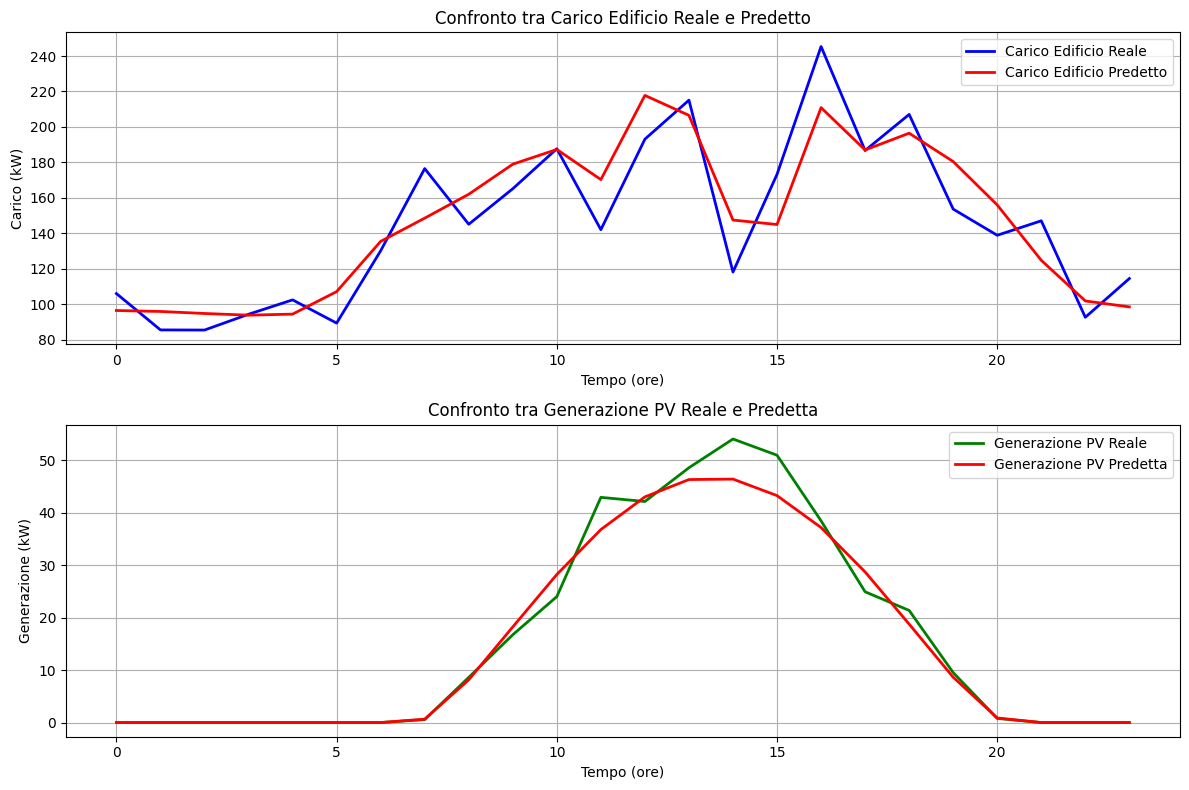

In [187]:
############# IN QUESTA CELLA SI TESTANO I PROFILI PREDETTI E REALI E SI CONFRONTANO ##########################

forecasted_load=process_building_load(buildingLoadScaling)
real_load=real_building_load(buildingLoadScaling)

forecasted_production=process_pv_production()
real_production=real_PV_production()

print('Il profilo di carico elettrico previsto è ',forecasted_load)
print('Il profilo di carico REALE è ',real_load)

print('Il profilo di generazione previsto è ',forecasted_production)
print('Il profilo di generazione REALE è ',real_production)



timestamps = np.arange(0, 24, init_val['timestamp']/60.)
plt.figure(figsize=(12, 8))

# Grafico per il carico dell'edificio
plt.subplot(2, 1, 1)
plt.plot(timestamps, real_load, label='Carico Edificio Reale', color='blue', linewidth=2)
plt.plot(timestamps, forecasted_load, label='Carico Edificio Predetto', color='red', linewidth=2)
plt.title('Confronto tra Carico Edificio Reale e Predetto')
plt.xlabel('Tempo (ore)')
plt.ylabel('Carico (kW)')
plt.legend()
plt.grid(True)

# Grafico per la generazione da fotovoltaico
plt.subplot(2, 1, 2)
plt.plot(timestamps, real_production, label='Generazione PV Reale', color='green', linewidth=2)
plt.plot(timestamps, forecasted_production, label='Generazione PV Predetta', color='red', linewidth=2)
plt.title('Confronto tra Generazione PV Reale e Predetta')
plt.xlabel('Tempo (ore)')
plt.ylabel('Generazione (kW)')
plt.legend()
plt.grid(True)

# Mostra i grafici
plt.tight_layout()
plt.show()

In [237]:
######################## QUESTA è LA CELLA PER LA PROVA PRINCIPALE DEL LOOP ############################

# Creiamo un nuovo array per memorizzare i risultati senza modificare l'originale
new_schedule = np.copy(schedule)

# Ciclo per ogni intervallo di tempo
for time in range(int((60/init_val['timestamp'])*24)):
    for station in range(init_val['numChargers']):
        # Prendiamo i valori fino all'indice "time" escluso dalla versione originale "schedule"
        values_to_add = schedule[station, :time]
        
        # Concatenazione dei valori in coda allo stesso vettore in "new_schedule"
        new_schedule[station] = np.concatenate((schedule[station], values_to_add))[time:]
    print(new_schedule[0],time)

    new_power_pv = np.concatenate((power_pv, power_pv[:time]))[time:]
 
    new_power_consumption = np.concatenate((power_consumption, power_consumption[:time]))[time:]

    new_costi_in = np.concatenate((costi_in, costi_in[:time]))[time:]

    new_costi_out = np.concatenate((costi_out, costi_out[:time]))[time:]

    print(f'All iterazione numero {time} si ottengono i seguenti risultati ', optimization(new_schedule, new_power_pv, new_power_consumption, new_costi_in, new_costi_out, user_cost, timeStamp))

#print(optimization(new_schedule, new_power_pv, new_power_consumption, new_costi_in, new_costi_out, user_cost, timeStamp))

[0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0] 0
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\metell1l\AppData\Local\Temp\tmp8xxf69rk.glpk.raw --wglp
 C:\Users\metell1l\AppData\Local\Temp\tmpy001nr3j.glpk.glp --cpxlp C:\Users\metell1l\AppData\Local\Temp\tmp0khy17_2.pyomo.lp
Reading problem data from 'C:\Users\metell1l\AppData\Local\Temp\tmp0khy17_2.pyomo.lp'...
C:\Users\metell1l\AppData\Local\Temp\tmp0khy17_2.pyomo.lp:10448: warning: lower bound of variable 'x1818' redefined
C:\Users\metell1l\AppData\Local\Temp\tmp0khy17_2.pyomo.lp:10448: warning: upper bound of variable 'x1818' redefined
1839 rows, 1536 columns, 3049 non-zeros
624 integer variables, all of which are binary
11072 lines were read
Writing problem data to 'C:\Users\metell1l\AppData\Local\Temp\tmpy001nr3j.glpk.glp'...
8796 lines were written
GLPK Integer Optimizer, v4.65
1839 rows, 1536 columns, 3049 non-zeros
624 integer variables, all of which are binary
Preprocessing

IndexError: list index out of range

In [235]:
time=8   ############ SEMBRA CHE LA FUNZIONE OPTIMIZATION ABBIA PROBLEMI QUANDO PRENDE IN INPUT UNA SCHEDULE CHE INIZIA GIA CON UN UNO! #################

for station in range(init_val['numChargers']):
    # Prendiamo i valori fino all'indice "time" escluso dalla versione originale "schedule"
    values_to_add = schedule[station, :time]
    
    # Concatenazione dei valori in coda allo stesso vettore in "new_schedule"
    new_schedule[station] = np.concatenate((schedule[station], values_to_add))[time:]
print(f'Schedule partendo dalle ore {time}', new_schedule[0],time)

new_power_pv = np.concatenate((power_pv, power_pv[:time]))[time:]
print(f'PV production partendo dalle ore {time}', new_power_pv[0],time)

new_power_consumption = np.concatenate((power_consumption, power_consumption[:time]))[time:]
print(f'Bulding load partendo dalle ore {time}', new_power_consumption[0],time)

new_costi_in = np.concatenate((costi_in, costi_in[:time]))[time:]

new_costi_out = np.concatenate((costi_out, costi_out[:time]))[time:]

print(f'All iterazione numero {time} si ottengono i seguenti risultati ', optimization(new_schedule, new_power_pv, new_power_consumption, new_costi_in, new_costi_out, user_cost, timeStamp))

Schedule partendo dalle ore 8 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 8
PV production partendo dalle ore 8 37.1741327415437 8
Bulding load partendo dalle ore 8 210.91139999999996 8
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\metell1l\AppData\Local\Temp\tmpqdv6e6kp.glpk.raw --wglp
 C:\Users\metell1l\AppData\Local\Temp\tmprgle4rac.glpk.glp --cpxlp C:\Users\metell1l\AppData\Local\Temp\tmppy6jlwfj.pyomo.lp
Reading problem data from 'C:\Users\metell1l\AppData\Local\Temp\tmppy6jlwfj.pyomo.lp'...
C:\Users\metell1l\AppData\Local\Temp\tmppy6jlwfj.pyomo.lp:10448: warning: lower bound of variable 'x1818' redefined
C:\Users\metell1l\AppData\Local\Temp\tmppy6jlwfj.pyomo.lp:10448: warning: upper bound of variable 'x1818' redefined
1839 rows, 1536 columns, 3049 non-zeros
624 integer variables, all of which are binary
11072 lines were read
Writing problem data to 'C:\Users\metell1l\AppData\Local\Temp\tmprgle4rac.glpk.glp'...
8796 lines were

In [198]:
print(power_pv)
print(power_consumption)

[ 0.          0.          0.          0.          0.          0.
  0.          0.64587359  8.15126936 18.23672581 28.23013915 36.79191586
 43.02186987 46.32883444 46.41277323 43.26617079 37.17413274 28.71280514
 18.76513398  8.63974046  0.87049848  0.          0.          0.        ]
[ 96.53805  95.9994   94.86225  93.90465  94.50315 107.19135 135.5004
 148.60755 162.0738  179.01135 187.3305  170.3331  217.79415 206.54235
 147.53025 145.01655 210.9114  187.03125 196.48755 180.5076  156.02895
 124.8471  101.92455  98.57295]


In [245]:
print(new_schedule)

soc_values = [
    [0.4, 0.5],  # SOC iniziali per Station 0
    [0.4, 0.5],  # SOC iniziali per Station 1
    [0.4, 0.5],  # SOC iniziali per Station 2
    [0.4],   # SOC iniziali per Station 3
    [0.4],  # SOC iniziali per Station 4
    [0.4],  # SOC iniziali per Station 5
    [0.2],  # SOC iniziali per Station 6
    [0.2],  # SOC iniziali per Station 7
    [0.2],  # SOC iniziali per Station 8
    [0],  # SOC iniziali per Station 9
    [0.5],  # SOC iniziali per Station 10
    [0.5]  # SOC iniziali per Station 11
]
battery_capacity_values = [
    [13, 13],  # SOC iniziali per Station 0
    [42, 42],  # SOC iniziali per Station 1
    [75, 75],  # SOC iniziali per Station 2
    [42],   # SOC iniziali per Station 3
    [13],  # SOC iniziali per Station 4
    [26.8],  # SOC iniziali per Station 5
    [75],  # SOC iniziali per Station 6
    [26.8],  # SOC iniziali per Station 7
    [75],  # SOC iniziali per Station 8
    [0],  # SOC iniziali per Station 9
    [42],  # SOC iniziali per Station 10
    [75]  # SOC iniziali per Station 11
]
EV_nominal_power_values =[
    [3.6, 3.6],  # SOC iniziali per Station 0
    [11, 11],  # SOC iniziali per Station 1
    [11, 11],  # SOC iniziali per Station 2
    [11],   # SOC iniziali per Station 3
    [3.6],  # SOC iniziali per Station 4
    [7.4],  # SOC iniziali per Station 5
    [11],  # SOC iniziali per Station 6
    [7.4],  # SOC iniziali per Station 7
    [11],  # SOC iniziali per Station 8
    [0],  # SOC iniziali per Station 9
    [250],  # SOC iniziali per Station 10
    [250]  # SOC iniziali per Station 11
]
EV_nominal_power_values_v2g =[
    [3.6, 3.6],  # SOC iniziali per Station 0
    [11, 11],  # SOC iniziali per Station 1
    [11, 11],  # SOC iniziali per Station 2
    [11],   # SOC iniziali per Station 3
    [3.6],  # SOC iniziali per Station 4
    [7.4],  # SOC iniziali per Station 5
    [11],  # SOC iniziali per Station 6
    [7.4],  # SOC iniziali per Station 7
    [11],  # SOC iniziali per Station 8
    [0],  # SOC iniziali per Station 9
    [250],  # SOC iniziali per Station 10
    [250]  # SOC iniziali per Station 11
]
power_CP_values = [
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 50, 50  #kW
    ]
residence_times = calculate_residence_times(new_schedule)
print(residence_times)

PchMax_vehicles_values=calculate_pchmax_vehicles(EV_nominal_power_values, power_CP_values)
PdchMax_vehicles_values=calculate_pdchmax_vehicles(EV_nominal_power_values_v2g, power_CP_values)
final_soc_values=calculate_final_soc(soc_values, PchMax_vehicles_values, residence_times, battery_capacity_values)

print('I valori di SOC finale calcolati sono ', final_soc_values)
print(soc_values)
nWB=12
nTimeStamp=24
########## CREO GLI INPUT DI TIPO VETTORIALE, SUGLI N TIMESTAMP DELLA SIMULAZIONE ##########

# Array vuoti per memorizzare i valori
initial_soc = np.zeros_like(schedule, dtype=float)
battery_capacity = np.zeros_like(schedule, dtype=float)
PchMax_vehicles = np.zeros_like(schedule, dtype=float)
PdchMax_vehicles = np.zeros_like(schedule, dtype=float)
final_soc = np.zeros_like(schedule, dtype=float)

# Loop su ogni stazione
for station in range(nWB):
    index = 0  # Indice per il SOC del veicolo connesso
    
    # Loop su ogni timestamp
    for t in range(nTimeStamp):
        if schedule[station, t] == 1:  # Se il veicolo è connesso
            initial_soc[station, t] = soc_values[station][index]
            battery_capacity[station, t] = battery_capacity_values[station][index]
            PchMax_vehicles[station, t] = PchMax_vehicles_values[station][index]
            PdchMax_vehicles[station, t] = PdchMax_vehicles_values[station][index]
            final_soc[station, t] = final_soc_values[station][index]
        
        # Controlla la transizione da 1 a 0 per cambiare veicolo
        if t > 0 and schedule[station, t] == 0 and schedule[station, t-1] == 1:
            index += 1  # Passa al prossimo veicolo, se disponibile
np.set_printoptions(threshold=np.inf)

print(initial_soc)

[[1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[240, 240], [240, 240], [240, 240], [540], [540], [540], [180], [300], [240, 60], [], [60], [60]]
I valori di SOC finale calcolati sono  [[0.7, 0.7], [0.7, 0.7], [0.7, 0.7], [0.7], [0.7], [0.7], [0.508], [0.7], [0.6106666666666667], [0], [0.7], [0.7]]
[[0.4, 0.5], [0.4, 0.5], [0.4, 0.5], [0.4], [0.4], [0.4], [0.2], [0.2], [0.2], [0], [0.5], [0.5]]
[[0.  0.  0.  0.  0.  0.  0.  0.  0.

In [238]:
print(new_schedule)
print(schedule)

[[1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 

In [ ]:
######### PROVA FATTA CON GIORGIO #############


schedule=schedule.tolist()
for time in range(int((60/init_val['timestamp'])*24)):
    for idx,elm in enumerate(schedule):
        schedule[idx]=elm[time:]+elm[:time]
    print(schedule[0],time)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] 2
[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 3
[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 4
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1] 5
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0] 6
[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 7
[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1] 8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0] 9
[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 10
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1] 11
[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 12
[0, 0, 0, 0, 0, 0, 0, 